## Information on the data:
### BigMart Sales Prediction problem

#### TASK: predict the sales for test data set.

#### Data Information::
Item_Identifier: Unique product ID

Item_Weight: Weight of product

Item_Fat_Content: Whether the product is low fat or not

Item_Visibility: The % of total display area of all products in a store allocated to the particular product

Item_Type: The category to which the product belongs

Item_MRP: Maximum Retail Price (list price) of the product

Outlet_Identifier: Unique store ID

Outlet_Establishment_Year: The year in which store was established

Outlet_Size: The size of the store in terms of ground area covered

Outlet_Location_Type: The type of city in which the store is located

Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

#### Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

### Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
# load the datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
# Information on the train data( number of data points and features)
print("Train data shape is:", {train_data.shape})
train_data.head()

Train data shape is: {(8523, 12)}


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Notes:
* Item_weight count differs from the rest i.e 7060 and not 8523


In [4]:
#Get information on the different variables and their data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Categorical Variables
1. Item_Identifier
2. Item_Fat_Content
3. Item_Type
4. Outlet_Identifier
5. Outlet_Size
6. Outlet_Location_Type
7. Outlet_Type        
 

### Step 2: Data Cleaning
#### 1: Check for duplicates

In [5]:
train_data.duplicated().sum()

0

#### 2: Check for NAN's

In [6]:
train_data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### We need to replace the Item_Weight NANs with the mean
#### For Outlet_Size, we will replace the NANs with the mode since it is a categorical variable

In [7]:
# Replacing with the mean
mean_item_weight = train_data['Item_Weight'].mean()
# Replace the NANs
train_data['Item_Weight'].fillna(mean_item_weight, inplace=True)


In [8]:
# Replacing the mode
# To get the mode of the different Outlet sises, we need to categorise each in relation to Outlet type (They are correlated)
# We should create a pivot table 
outlet_size_pivot = train_data.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x: x.mode()[0]))
print(outlet_size_pivot)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [9]:
# We find that the mode for the Grocery Store & Supermarket Type1 is Small, and both Supermarket Type2 & Supermarket Type3 have a mode of Medium
# Replace the NANs with the respective values
def mode_replacement(df, col):
   # Define the function to apply to each row
    for index, row in df.iterrows():
        if pd.isna(row[col]) and (row['Outlet_Type'] == 'Grocery Store' or row['Outlet_Type'] == 'Supermarket Type1'):
            df.at[index, col] = 'Small'
        elif pd.isna(row[col]):
            df.at[index, col] = 'Medium'

In [10]:
# Apply mode replacement
mode_replacement(train_data, 'Outlet_Size')
train_data.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [11]:
# Statistical measure of the data
# Train data description
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8523.0,12.857645,4.226124,4.555,9.310000,12.857645,16.000000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


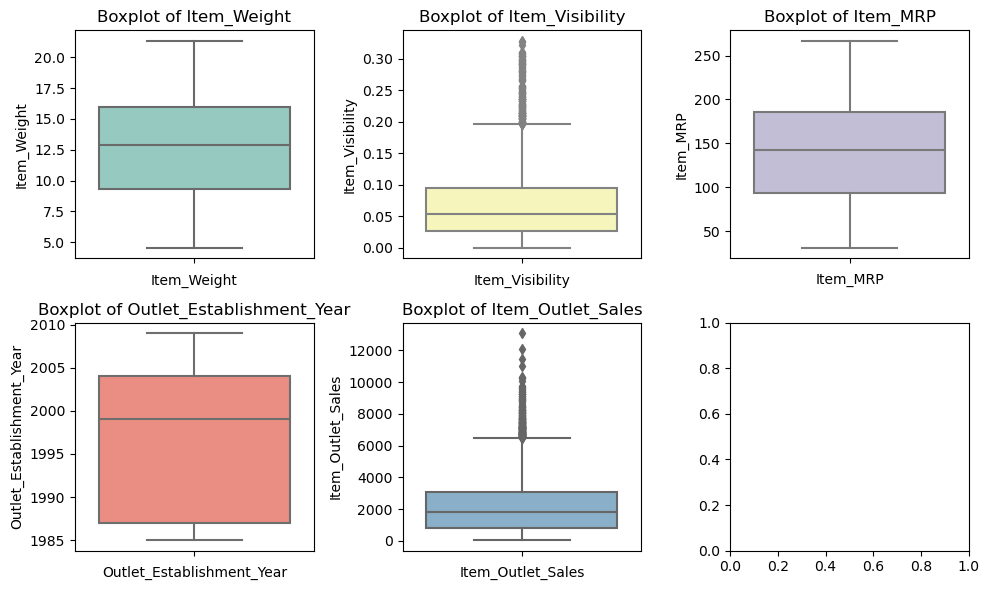

In [12]:
# Plot the distributions
variables  = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Flatten the axes array for easy indexing
axes = axes.flatten()
# Define a color palette with different colors for each boxplot
palette = sns.color_palette("Set3", len(variables))
# Plot the distributions
for index, col in enumerate(variables):
    sns.boxplot(y=train_data[col], ax=axes[index], color=palette[index])
    axes[index].set_title(f'Boxplot of {col}')
    axes[index].set_xlabel(col)

plt.tight_layout()
plt.show()

### Visualizing categorical variables

#### Item 1: Item_Fat_Content

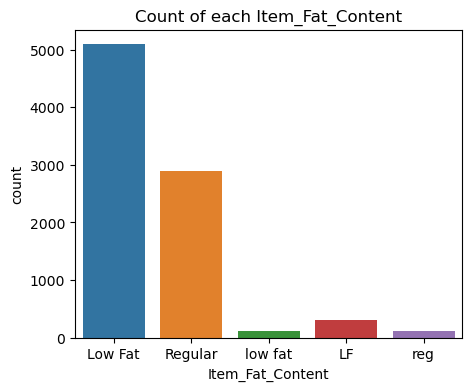

In [13]:
# Item_Fat_Content
plt.figure(figsize= (5,4))
sns.countplot(x= 'Item_Fat_Content', data = train_data)
plt.title("Count of each Item_Fat_Content")
plt.show()

#### Note that Low fat has been presented in 3 formats while Regular is in 2 formats.
We need to change that to 2 distinct values

In [14]:
#train_data['Item_Fat_Content'] 
Fat = ["Low Fat", "low fat", "LF"]
regular = ['Regular', 'reg']

def fat_content(df, col):
    for index, row in df.iterrows():
        if row[col] in Fat:
            df.at[index, col] = 'Low Fat'
        elif row[col] in regular:
            df.at[index, col] = 'Regular'
fat_content(train_data, 'Item_Fat_Content')

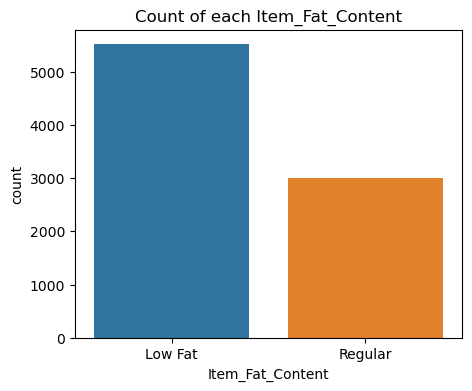

In [15]:
# Item_Fat_Content
plt.figure(figsize= (5,4))
sns.countplot(x= 'Item_Fat_Content', data = train_data)
plt.title("Count of each Item_Fat_Content")
plt.show()

#### Item 2: Item_Type

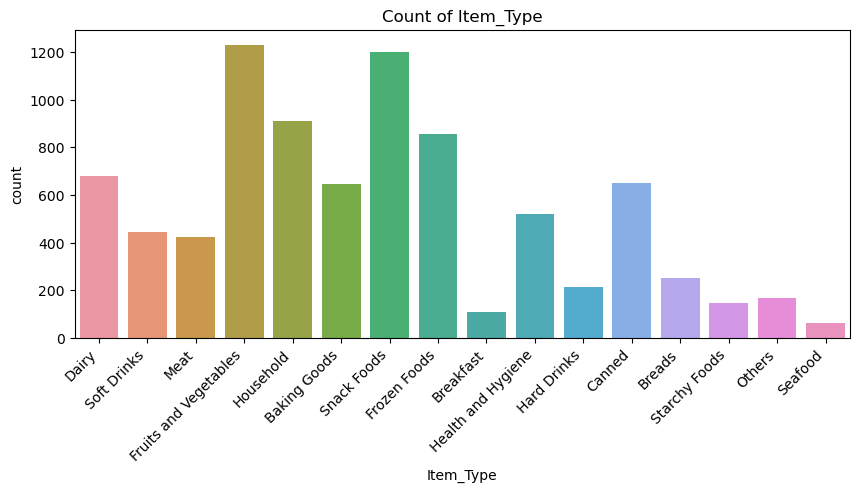

In [16]:
# Item_Type
plt.figure(figsize= (10,4))
ax = sns.countplot(x='Item_Type', data=train_data)
sns.countplot(x= 'Item_Type', data = train_data)
plt.title("Count of Item_Type")
plt.xticks(rotation = 45)
# Set the x-tick labels for each bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.show()

#### Item 3: Outlet_Identifier

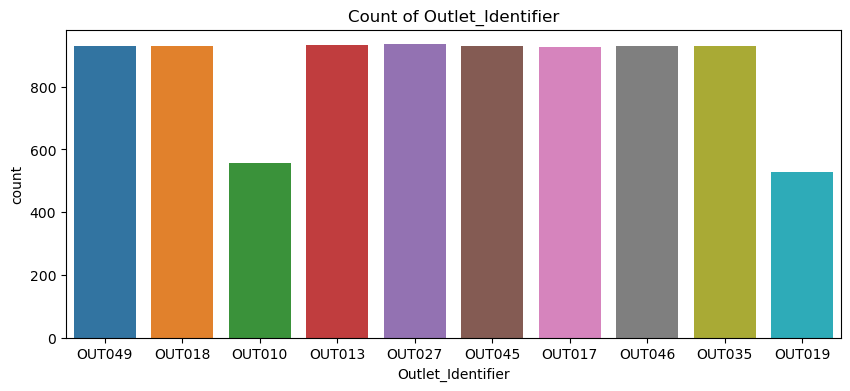

In [17]:
# Outlet_Identifier
plt.figure(figsize= (10,4))
sns.countplot(x= 'Outlet_Identifier', data = train_data)
plt.title("Count of Outlet_Identifier")
plt.show()

#### Item 4: Outlet_Size

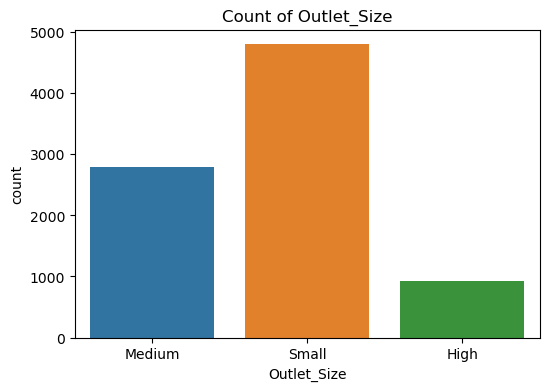

In [18]:
# Outlet_Size
plt.figure(figsize= (6,4))
sns.countplot(x= 'Outlet_Size', data = train_data)
plt.title("Count of Outlet_Size")
plt.show()

#### Item 5: Outlet_Location_Type

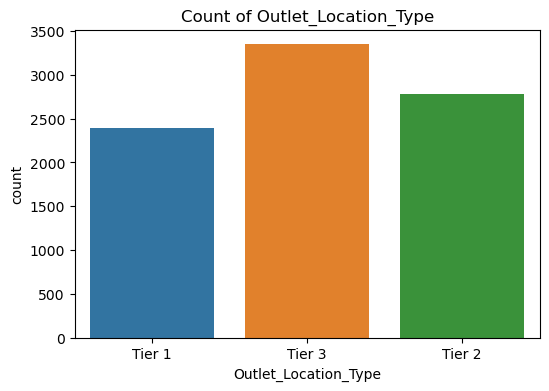

In [19]:
#Outlet_Location_Type
plt.figure(figsize= (6,4))
sns.countplot(x= 'Outlet_Location_Type', data = train_data)
plt.title("Count of Outlet_Location_Type")
plt.show()

#### Item 6: Outlet_Type

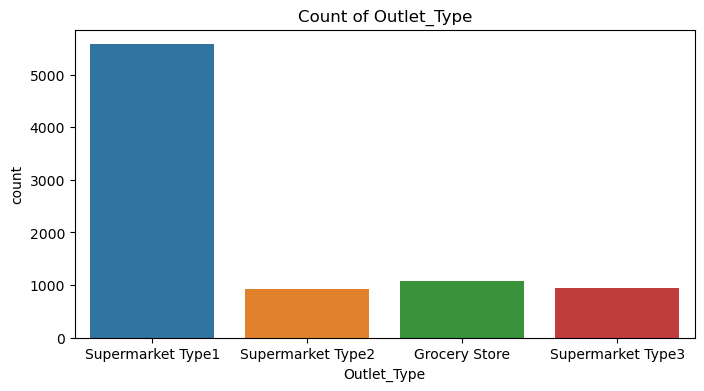

In [20]:
# Outlet_Type
plt.figure(figsize= (8,4))
sns.countplot(x= 'Outlet_Type', data = train_data)
plt.title("Count of Outlet_Type")
plt.show()

### Step 3: Data Preprocessing

In [21]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##### 1. Label Encoding

In [22]:
# Encode the categorical variables
# use label encoding
encoder = LabelEncoder()
encoded_columns = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

def col_encode(df, column):
    df[column] = encoder.fit_transform(df[column])

# Apply the function to each column
for col in encoded_columns:
    col_encode(train_data, col)

In [37]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


##### 2. Splitting the data

In [23]:
# Split the data into target and features
X = train_data.drop(columns = "Item_Outlet_Sales", axis = 1)
y = train_data['Item_Outlet_Sales']

In [24]:
# split the data into training and estinf datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

In [25]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


### Step 4: Model training

In [26]:
xgb = XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)
lr = LinearRegression()
rf = RandomForestRegressor(max_depth = 3, random_state = 42)

In [27]:
# train the models
def model_training(X_train, X_test, y_train, y_test):
    # train the different models
    lr_model = lr.fit(X_train, y_train)
    rf_model = rf.fit(X_train, y_train)
    xgb_model = xgb.fit(X_train, y_train)
    # test the models
    # Convert the testing data into DMatrix format
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_lr =lr_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_test)

    # Check model performance
    # xgboost
    r2_xgb = r2_score(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

    # lr
    r2_lr = r2_score(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    # rf
    r2_rf = r2_score(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    # Create a DataFrame to store results
    results_df = pd.DataFrame({'Model': ['XGBoost', 'Linear Regression', 'Random Forest'],
        'R2 Score': [r2_xgb, r2_lr, r2_rf], 'MSE': [mae_xgb, mae_lr, mae_rf]})


    return results_df

In [28]:
models= model_training(X_train, X_test, y_train, y_test)
models

C:\Users\user\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [04:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


,Model,R2 Score,MSE
0,XGBoost,0.603701,725.896822
1,Linear Regression,0.520160,855.580681
2,Random Forest,0.555714,781.482747


#### The XGBoost model has the highest R-squared score and the lowest Mean Squared Error (MSE), indicating better performance compared to the other models.
#### Therefore, the XGBoost model appears to be the best model among the three.

### Step 5: Sales Prediction

In [29]:
# Check the test data
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [30]:
# check for na's
test_data.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [31]:
# Replacing with the mean
mean_item_weight = test_data['Item_Weight'].mean()
# Replace the NANs
test_data['Item_Weight'].fillna(mean_item_weight, inplace=True)

In [32]:
# Replace the NANs with the respective values
# Apply mode replacement
mode_replacement(test_data, 'Outlet_Size')
train_data.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [33]:
# data cleaning
fat_content(test_data, 'Item_Fat_Content')

In [34]:
# label encoding
# Encode the categorical variables
encoder = LabelEncoder()
encoded_columns = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

def col_encode(df, column):
    df[column] = encoder.fit_transform(df[column])

# Apply the function to each column
for col in encoded_columns:
    col_encode(test_data, col)

In [35]:
# predict the "Item_Outlet_Sales" given the data
xgb = XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)
xgb_model = xgb.fit(X_train, y_train)
test_data['Item_Outlet_Sales'] = xgb_model.predict(test_data)
print(test_data['Item_Outlet_Sales'].head(10))

0    1662.993774
1    1382.829590
2     597.253540
3    2343.581787
4    5839.812012
5    1966.266968
6     731.594421
7    2141.987061
8    1447.369385
9    3095.612549
Name: Item_Outlet_Sales, dtype: float32


C:\Users\user\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [04:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [36]:
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1103,20.750000,0,0.007565,13,107.8622,9,1999,1,0,1,1662.993774
1,1067,8.300000,1,0.038428,4,87.3198,2,2007,2,1,1,1382.829590
2,1406,14.600000,0,0.099575,11,241.7538,0,1998,2,2,0,597.253540
3,809,7.315000,0,0.015388,13,155.0340,2,2007,2,1,1,2343.581787
4,1184,12.695633,1,0.118599,4,234.2300,5,1985,1,2,3,5839.812012
